<a href="https://colab.research.google.com/github/OlegKret/---/blob/master/Fuzzy_Ligik_example(simulate).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

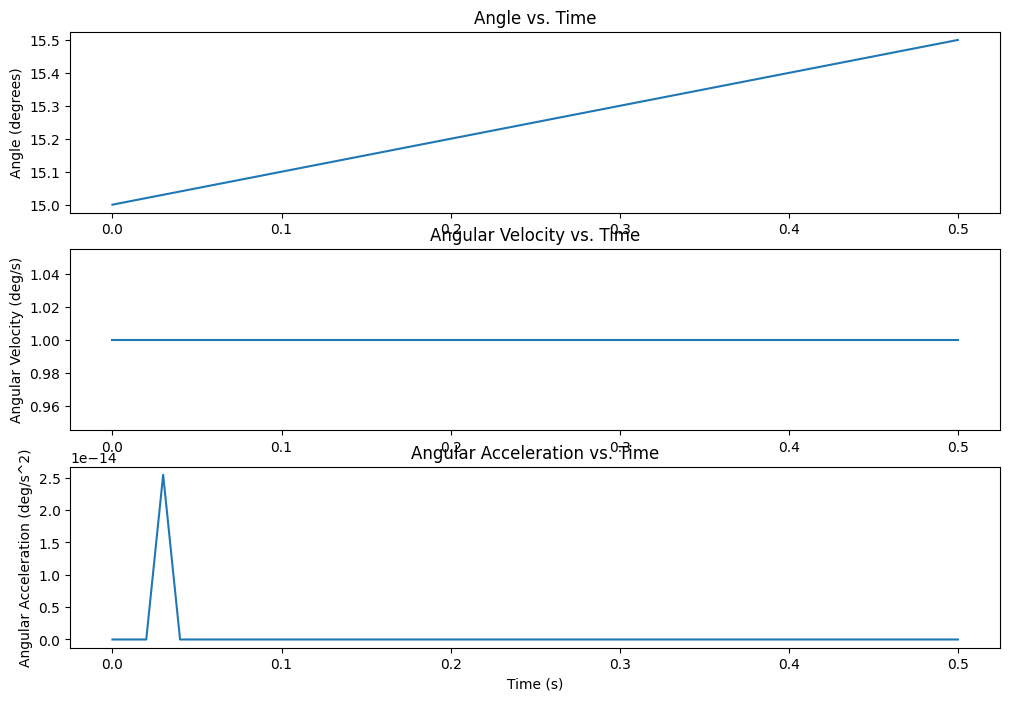

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
c = 0.01  # Integration step
T = 50 * c  # Simulation duration
a_min = -2.0  # Minimum angular acceleration (rad/s^2)
a_max = 2.0  # Maximum angular acceleration (rad/s^2)
angle_min, angle_max = -90, 90  # Physical range for angle in degrees
angular_velocity_min, angular_velocity_max = -30, 30  # Physical range for angular velocity in deg/s

# Fuzzy Logic Components
def get_membership_value(x, a, b, c, d):
    """Calculates membership value for the trapezoidal MF."""
    if x <= a or x >= d:
        return 0
    elif a < x < b:
        return (x - a) / (b - a)
    elif b <= x <= c:
        return 1
    else:  # c < x < d
        return (d - x) / (d - c)

def fuzzify(value):
    """Fuzzifies a value using triangular MFs."""
    membership_values = {
        "NV": get_membership_value(value, -100, -100, -75, -25),
        "NS": get_membership_value(value, -75, -25, -25, 0),
        "NM": get_membership_value(value, -25, 0, 0, 25),
        "PM": get_membership_value(value, 0, 25, 25, 75),
        "PS": get_membership_value(value, 25, 75, 75, 100),
        "PV": get_membership_value(value, 75, 100, 100, 100),
    }
    return membership_values

def fuzzy_inference(angle_fuzzy, velocity_fuzzy, rule_base):
    """Performs fuzzy inference with aggregation, activation, and defuzzification."""

    # Modify term names to match the fuzzy sets
    term_names = ["NV", "NS", "NM", "PM", "PS", "PV"]

    truncated_fuzzy_sets = {}
    for (n1, n2), m in rule_base.items():
        if angle_fuzzy[term_names[n1 - 1]] > 0 and velocity_fuzzy[term_names[n2 - 1]] > 0:  # Access using term_names
            term_name = term_names[m - 1]
            rule_strength = min(angle_fuzzy[term_names[n1 - 1]], velocity_fuzzy[term_names[n2 - 1]])
            truncated_fuzzy_sets[term_name] = max(
                truncated_fuzzy_sets.get(term_name, 0), rule_strength
            )

    overall_fuzzy_set = accumulate(truncated_fuzzy_sets)
    centroid = defuzzify(overall_fuzzy_set)
    return centroid


def aggregate_and_activate(angle_fuzzy, velocity_fuzzy, rule_base):
    """Performs aggregation and activation of fuzzy rules."""
    active_rules = []
    for (n1, n2), m in rule_base.items():
        if angle_fuzzy[f"N{n1}"] > 0 and velocity_fuzzy[f"N{n2}"] > 0:
            active_rules.append((n1, n2, m))

    truncated_fuzzy_sets = {}
    for n1, n2, m in active_rules:
        rule_strength = min(angle_fuzzy[f"N{n1}"], velocity_fuzzy[f"N{n2}"])
        term_name = f"N{m}"  # Output term name
        truncated_fuzzy_sets[term_name] = max(
            truncated_fuzzy_sets.get(term_name, 0), rule_strength
        )
    return truncated_fuzzy_sets

def accumulate(truncated_fuzzy_sets):
    """Accumulates truncated fuzzy sets to form the overall fuzzy set."""
    overall_fuzzy_set = {}
    for term, membership_value in truncated_fuzzy_sets.items():
        for x in range(-100, 101):  # Assuming dimensionless range
            overall_fuzzy_set[x] = max(
                overall_fuzzy_set.get(x, 0), membership_value
            )  # Take the maximum membership for each point
    return overall_fuzzy_set

def defuzzify(overall_fuzzy_set):
    """Performs centroid defuzzification."""
    numerator = 0
    denominator = 0
    for x, membership_value in overall_fuzzy_set.items():
        numerator += x * membership_value
        denominator += membership_value

    if denominator == 0:
        return 0  # Avoid division by zero (optional handling)

    centroid = numerator / denominator
    return centroid


def scale_to_dimensionless(value, value_min, value_max, target_min=-100, target_max=100):
    """Scales a value from a physical range to the dimensionless range."""
    return target_min + (value - value_min) * (target_max - target_min) / (value_max - value_min)


def scale_from_dimensionless(value, value_min, value_max, target_min=-100, target_max=100):
    """Scales a value from the dimensionless range back to its physical range."""
    return value_min + (value - target_min) * (value_max - value_min) / (target_max - target_min)


# Rule Base
rule_base = {
    (1, 1): 6, (1, 2): 6, (1, 3): 6, (1, 4): 6, (1, 5): 6, (1, 6): 6,
    (2, 1): 6, (2, 2): 6, (2, 3): 6, (2, 4): 5, (2, 5): 5, (2, 6): 5,
    (3, 1): 6, (3, 2): 6, (3, 3): 6, (3, 4): 5, (3, 5): 5, (3, 6): 5,
    (4, 1): 2, (4, 2): 2, (4, 3): 2, (4, 4): 1, (4, 5): 1, (4, 6): 1,
    (5, 1): 2, (5, 2): 2, (5, 3): 2, (5, 4): 1, (5, 5): 1, (5, 6): 1,
    (6, 1): 1, (6, 2): 1, (6, 3): 1, (6, 4): 1, (6, 5): 1, (6, 6): 1,
}

# Input Data (initial conditions in radians)
initial_angle = np.radians(15)
initial_angular_velocity = np.radians(1)

# Simulation Loop
time = [0]  # Initialize time with 0
angle = [initial_angle]
angular_velocity = [initial_angular_velocity]
angular_acceleration = [0] # Initialize with 0

for t in np.arange(0, T, c):  # Start at 0 to include the initial state
    # 1. Scaling to Dimensionless Range
    angle_dim = scale_to_dimensionless(angle[-1], angle_min, angle_max)
    angular_velocity_dim = scale_to_dimensionless(angular_velocity[-1], angular_velocity_min, angular_velocity_max)




    # 2. Fuzzification
    angle_fuzzy = fuzzify(angle_dim)
    velocity_fuzzy = fuzzify(angular_velocity_dim)

    # 3. Fuzzy Inference
    control_output = fuzzy_inference(angle_fuzzy, velocity_fuzzy, rule_base)

    # 4. Scaling Back to Physical Range
    a = scale_from_dimensionless(control_output, a_min, a_max, -100, 100)
    a = np.clip(a, a_min, a_max)

    # 5. Integration (Euler Method)
    angle.append(angle[-1] + c * angular_velocity[-1])
    angular_velocity.append(angular_velocity[-1] + c * a)
    angular_acceleration.append(a)
    time.append(t + c)  # Update time after integration


# Output to File (convert back to degrees for output)
with open("simulation_output.txt", "w") as file:
    for t, a, v, acc in zip(time, angle, angular_velocity, angular_acceleration):
        file.write(
            f"{t:.2f} {np.degrees(a):.2f} {np.degrees(v):.2f} {np.degrees(acc):.2f}\n"
        )

# Plotting (convert to degrees for plotting)
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(time, np.degrees(angle))
plt.title("Angle vs. Time")
plt.ylabel("Angle (degrees)")
plt.subplot(3, 1, 2)
plt.plot(time, np.degrees(angular_velocity))
plt.title("Angular Velocity vs. Time")
plt.ylabel("Angular Velocity (deg/s)")
plt.subplot(3, 1, 3)
plt.plot(time, np.degrees(angular_acceleration))
plt.title("Angular Acceleration vs. Time")
plt.ylabel("Angular Acceleration (deg/s^2)")
plt.xlabel("Time (s)")
plt.show()